# Utility Functions

In [1]:
import pandas as pd
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import random

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, render_range):
        self.volume = deque(maxlen=render_range)
        self.net_worth = deque(maxlen=render_range)
        self.render_data = deque(maxlen=render_range)
        self.render_range = render_range

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

    # Render the environment to the screen
    def render(self, date, open, high, low, close, volume, net_worth, trades):
        # append volume and net_worth to deque list
        self.volume.append(volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        date = mpl_dates.date2num([pd.to_datetime(date)])[0]
        self.render_data.append([date, open, high, low, close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='red', colordown='blue', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        date_render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(date_render_range, self.volume, 0)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(date_render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in date_render_range:
                if trade['Type'] == 'buy':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='blue', label='blue', s = 120, edgecolors='none', marker="v")

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.yaxis.set_label_position('right')
        self.ax3.set_ylabel('Balance') # 여기 수정

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        plt.show(block=False)
        # Necessary to view frames before they are unrendered
        plt.pause(0.001)

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.Transition = namedtuple('Transition',
                                ('state', 'action', 'next_state', 'reward'))

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Model

In [219]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

class DQN(nn.Module):
    def __init__(self, action_space, state_size):
        super(DQN, self).__init__()
        self.action_space = action_space
        self.state_size = state_size
        self.state_size = self.state_size[0] * self.state_size[1]

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(500, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 64)
        self.layer4 = nn.Linear(64, self.action_space)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)
        #return self.layer4(x)

# Weight initialisation
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Environment

In [220]:
import numpy as np
import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
#from tensorboardX import SummaryWriter
import gymnasium as gym

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [373]:
class TradingEnv(gym.Env):
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, render_range = 100):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.render_range = render_range # render range in visualization

        self.batch_size = 64
        self.gamma = 0.99
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 1000
        self.tau = 0.1
        self.lr = 1e-4
        self.C = 24*7 # Update target every C steps (Update every week 원래 한달이었고 이거 성능 잘나왔음)
        self.losses = []
        self.ratio = 0.1

        self.memory = ReplayMemory(1000)
        self.loss = 0

        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1, 2])
        n_actions = len(self.action_space)

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (self.lookback_window_size, 10)

        self.Target = DQN(n_actions, self.state_size).to(device)
        self.Behaviour = DQN(n_actions, self.state_size).to(device)
        self.Target.apply(init_weights)
        self.Behaviour.apply(init_weights)

        self.optimizer = optim.Adam(self.Behaviour.parameters(), lr=self.lr)


    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(render_range=self.render_range) # init visualization
        self.trades = deque(maxlen=self.render_range) # limited orders memory for visualization
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
            self.market_history.append([self.df.loc[current_step, 'open'],
                                        self.df.loc[current_step, 'high'],
                                        self.df.loc[current_step, 'low'],
                                        self.df.loc[current_step, 'close'],
                                        self.df.loc[current_step, 'volume']
                                        ])

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'volume']
                                    ])
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.current_step, 'open'],
            self.df.loc[self.current_step, 'close'])
        date = self.df.loc[self.current_step, 'date_open'] # for visualization
        high = self.df.loc[self.current_step, 'high'] # for visualization
        low = self.df.loc[self.current_step, 'low'] # for visualization
        
        if action == 0: # Hold
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            # Buy with 100% of current balance
            self.crypto_bought = self.balance * self.ratio / current_price
            self.balance -= self.crypto_bought * current_price
            self.crypto_held += self.crypto_bought
            self.trades.append({'Date' : date, 'High' : high, 'Low' : low, 'Total': self.crypto_bought, 'Type': "buy"})

        elif action == 2 and self.crypto_held>0:
            # Sell 100% of current crypto held
            self.crypto_sold = self.crypto_held * self.ratio
            self.balance += self.crypto_sold * current_price
            self.crypto_held -= self.crypto_sold
            self.trades.append({'Date' : date, 'High' : high, 'Low' : low, 'Total': self.crypto_sold, 'Type': "sell"})

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
        #Write_to_file(Date, self.orders_history[-1])

        # Calculate reward
        reward = (self.net_worth - self.prev_net_worth)

        if self.net_worth <= self.initial_balance / 2:
            #reward = -10000
            done = True
        else:
            done = False

        obs = self._next_observation()
        
        return obs, reward, done

    # render environment
    def render(self, visualize=False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            date = self.df.loc[self.current_step, 'date_open']
            open = self.df.loc[self.current_step, 'open']
            close = self.df.loc[self.current_step, 'close']
            high = self.df.loc[self.current_step, 'high']
            low = self.df.loc[self.current_step, 'low']
            volume = self.df.loc[self.current_step, 'volume']

            # Render the environment to the screen
            self.visualization.render(date, open, high, low, close, volume, self.net_worth, self.trades)
    
    def act(self, state, testmode): # select_action에 대응
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        sample = random.random()
        # 초반에는 엡실론 값을 높게 하여 최대한 다양한 경험을 해보도록 하고, 점점 그 값을 낮춰가며 신경망이 결정하는 비율을 높인다
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-1 * self.current_step / self.eps_decay) 
        
        if testmode == False:
            if sample > eps_threshold:
                with torch.no_grad():
                    return self.Behaviour(state).max(1).indices.view(1,1)
            else:
                return torch.tensor([[np.random.choice(self.action_space)]], device=device, dtype=torch.long)
        else:
            return self.Target(state).max(1).indices.view(1,1)

    def save(self, name="dqn"):
        torch.save(self.Target.state_dict(), f'./dqn/{name}_Target.h5')
        torch.save(self.Behaviour.state_dict(), f'./dqn/{name}_Behaviour.h5')

    def load(self, name="dqn"):
        self.Target.load_state_dict(torch.load(f'./dqn/{name}_Target.h5', weights_only=True))
        #self.Behaviour.load_state_dict(torch.load(f'./dqn/{name}_Behaviour.h5', weights_only=True))
        self.Behaviour.load_state_dict(torch.load(f'./dqn/{name}_Target.h5', weights_only=True))
        
    def optimize_model(self):
        # Experience replay 메모리의 길이가 batch size (10)의 5배가 되기 전까지는 샘플링을 하지 않는다.
        if len(self.memory) < self.batch_size * 5:
            return
        Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        #with torch.no_grad():
        #    state_action_values = self.Target(state_batch).gather(1, action_batch)
        state_action_values = self.Target(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        #with torch.no_grad():
        #    next_state_values[non_final_mask] = self.Behaviour(non_final_next_states).max(1).values
        next_state_values[non_final_mask] = self.Behaviour(non_final_next_states).max(1).values
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        expected_state_action_values = expected_state_action_values.unsqueeze(1)

        # Compute Huber loss
        self.Behaviour.train()
        criterion = nn.HuberLoss()
        #criterion = nn.HuberLoss()
        self.loss = criterion(state_action_values, expected_state_action_values)#.unsqueeze(1)
        self.losses.append(self.loss)
        # Optimize the model
        self.optimizer.zero_grad()
        torch.nn.utils.clip_grad_value_(self.Behaviour.parameters(), 100) # Clipping before backward
        self.loss.backward()
        # In-place gradient clipping
        
        self.optimizer.step()
        
        # Update the target network every C step
        if self.current_step % self.C == 0:
            self.soft_update_target(self.Target, self.Behaviour)
    
    def soft_update_target(self, target, behaviour):
        for target_parameter, behaviour_parameter in zip(target.parameters(), behaviour.parameters()):
            target_parameter.data.copy_((1 - self.tau) * target_parameter.data + self.tau * behaviour_parameter)

In [374]:
def train_agent(env, visualize=False, train_episodes=1, training_batch_size=500):
    
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        for t in range(training_batch_size):
            env.render(visualize)
            action = env.act(state, testmode=False)
            next_state, reward, done = env.step(action)
            # 추가한 부분
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
            if done:
                break
            #action_onehot = np.zeros(3)
            #action_onehot[action] = 1
            env.memory.push(state, action, next_state, reward) # Store the transition in memory
            state = next_state
            env.optimize_model() # perform one step of the optimization on the policy network

        #torch.cat(env.losses, dim=0)
        print(f"Episode: {episode} Net worth: {env.net_worth}")
        print(f"Episode {episode} loss: {env.loss}")
        #print(f"Episode {episode} average loss: {torch.mean(env.losses)}")
        #if episode == train_episodes - 1:
            #env.save()

In [42]:
def test_agent(env, visualize=False, test_episodes=1):
    env.load() # load the model
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action = env.act(state, testmode=True)
            state, reward, done = env.step(action)
            print(f"Episode {episode} net_worth:, {env.net_worth}")
            #print(f"Episode {episode} average loss: {np.mean(env.losses)}")
            if env.current_step == env.end_step:
                break

In [280]:
len(memory2)

500

/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 0 Net worth: 971.3539180595093
Episode 0 loss: 293.8597412109375


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 1 Net worth: 1003.2582501173113
Episode 1 loss: 593.2232055664062


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 2 Net worth: 988.2389465876395
Episode 2 loss: 184.29898071289062


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 3 Net worth: 1007.3235172241467
Episode 3 loss: 120.27008819580078


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 4 Net worth: 1036.9967360540088
Episode 4 loss: 146.49319458007812


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 5 Net worth: 994.9649904748925
Episode 5 loss: 54.73773193359375


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 6 Net worth: 998.9094760339019
Episode 6 loss: 52.07475280761719


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 7 Net worth: 1014.9800549052632
Episode 7 loss: 165.7285919189453


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 8 Net worth: 996.4999050006112
Episode 8 loss: 257.4927978515625


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 9 Net worth: 1005.1404295313729
Episode 9 loss: 53.12376403808594


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 10 Net worth: 995.4037969980063
Episode 10 loss: 67.57109832763672


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 11 Net worth: 987.439723273885
Episode 11 loss: 546.6577758789062


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 12 Net worth: 1024.375229368157
Episode 12 loss: 782.0150146484375


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 13 Net worth: 990.0584979886286
Episode 13 loss: 90.85316467285156


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 14 Net worth: 1096.8118305448247
Episode 14 loss: 170.74649047851562


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 15 Net worth: 994.2440822977424
Episode 15 loss: 432.1989440917969


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 16 Net worth: 992.9564853862582
Episode 16 loss: 224.14532470703125


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 17 Net worth: 1015.4823901876191
Episode 17 loss: 276.38043212890625


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 18 Net worth: 997.5316910975777
Episode 18 loss: 211.25527954101562


/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/1373357421.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 19 Net worth: 1074.2856249553013
Episode 19 loss: 41.19506072998047


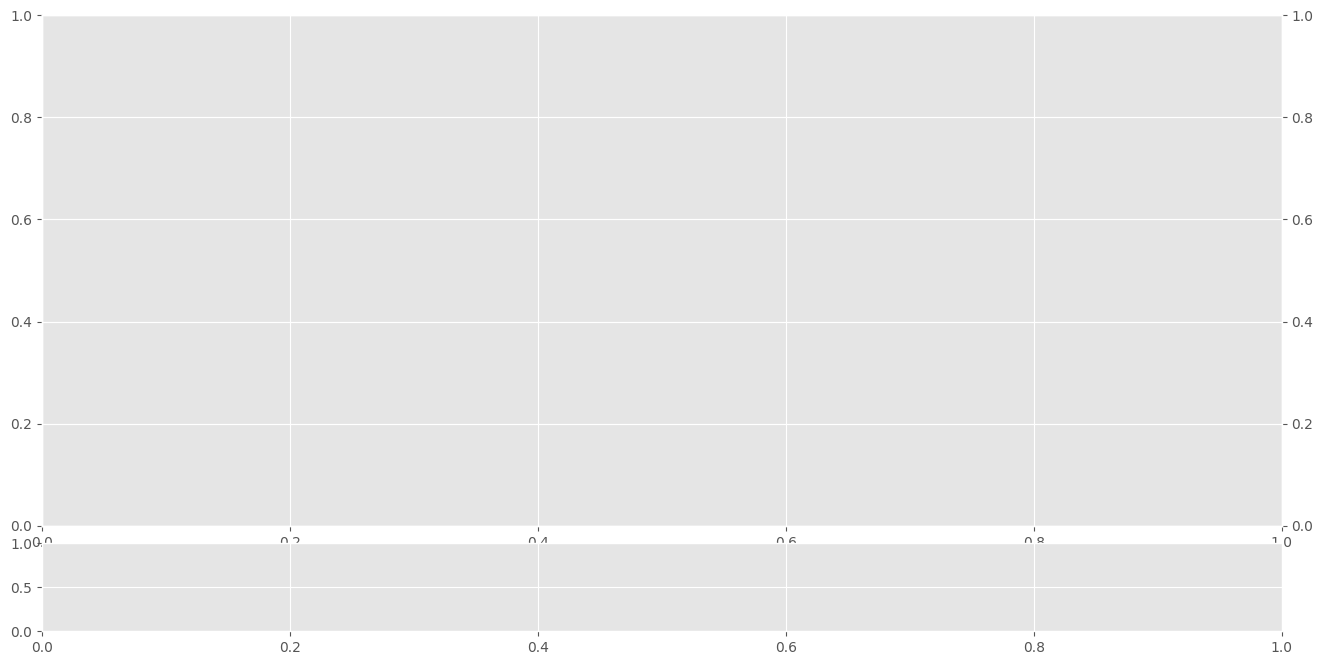

In [376]:
lookback_window_size = 50
data_path = "../data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]

lookback_window_size = 50

train_env = TradingEnv(train_df, lookback_window_size=lookback_window_size)

train_agent(train_env, visualize=False, train_episodes=20, training_batch_size=3000) # 4달 동안 거래 진행

In [377]:
test_df = df[train_size:]


test_env = TradingEnv(test_df, lookback_window_size=lookback_window_size)

test_agent(test_env, visualize=False, test_episodes=1)

FileNotFoundError: [Errno 2] No such file or directory: './dqn/dqn_Target.h5'

In [149]:
lookback_window_size = 50
data_path = "../data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]

lookback_window_size = 50
train_env = TradingEnv(train_df, lookback_window_size=lookback_window_size)

/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/3532252129.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


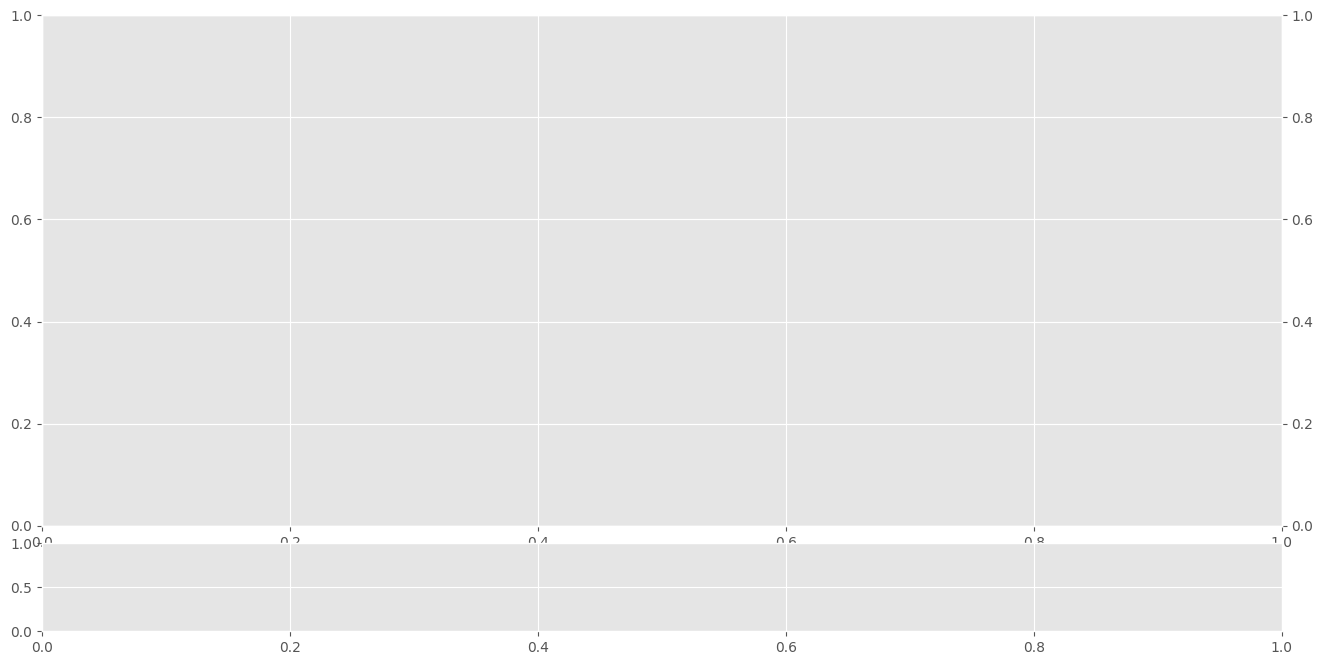

In [283]:
# 우선 100번 timestep만큼 돌려보자

lookback_window_size = 50
data_path = "../data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]

lookback_window_size = 50

train_env = TradingEnv(train_df, lookback_window_size=lookback_window_size)

memory = ReplayMemory(1000)

state = train_env.reset(env_steps_size = 500)
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

for _ in range(100):
    action = train_env.act(state, testmode=False)
    next_state, reward, done = train_env.step(action)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
    reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
    memory.push(state, action, next_state, reward)
    state = next_state
    #train_env.optimize_model()


In [284]:
Transition = namedtuple('Transition',
                ('state', 'action', 'next_state', 'reward'))

In [285]:
transitions = memory.sample(5)

In [286]:
batch = Transition(*zip(*transitions))

In [287]:
state.shape

torch.Size([1, 50, 10])

In [288]:
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                    batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.cat([s for s in batch.next_state
                                            if s is not None])
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

In [289]:
state_action_values = train_env.Target(state_batch).gather(1, action_batch)

In [290]:
state_action_values

tensor([[22488.3027],
        [22913.6582],
        [22518.2168],
        [22880.6055],
        [22977.6406]], device='mps:0', grad_fn=<GatherBackward0>)

In [291]:
state_action_values.shape

torch.Size([5, 1])

In [292]:
next_state_values = torch.zeros(5, device=device)
next_state_values[non_final_mask] = train_env.Behaviour(non_final_next_states).max(1).values

In [293]:
expected_state_action_values = (next_state_values * 0.99) + reward_batch


In [294]:
expected_state_action_values

tensor([40498.9531, 41001.0938, 41776.1094, 40411.8008, 40379.3047],
       device='mps:0', grad_fn=<AddBackward0>)

In [295]:
expected_state_action_values = expected_state_action_values.unsqueeze(1)
expected_state_action_values.shape

torch.Size([5, 1])

In [296]:
train_env.Behaviour.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(train_env.Behaviour.parameters(), lr=0.0001)
loss = criterion(state_action_values, expected_state_action_values)
loss.backward()
optimizer.step()

In [297]:
loss

tensor(3.2651e+08, device='mps:0', grad_fn=<MseLossBackward0>)

In [ ]:
        self.batch_size = 10
        self.gamma = 0.99
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 1000
        self.tau = 0.1
        self.lr = 1e-4
        self.C = 10 # Update target every C steps
        self.losses = []
        self.ratio = 0.1

loss 값이 너무 크지 않나?

In [ ]:
self.optimizer.zero_grad()

/var/folders/4w/q37s19t15xg3s29s2zm_1dcw0000gn/T/ipykernel_40545/2771068930.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Episode: 0 Net worth: 10948.409554957512
Episode 0 average loss: nan


/Users/fredjeong/Desktop/MATH70101 Deep Learning/Coursework III/dl-cw-3-gpu/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fredjeong/Desktop/MATH70101 Deep Learning/Coursework III/dl-cw-3-gpu/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


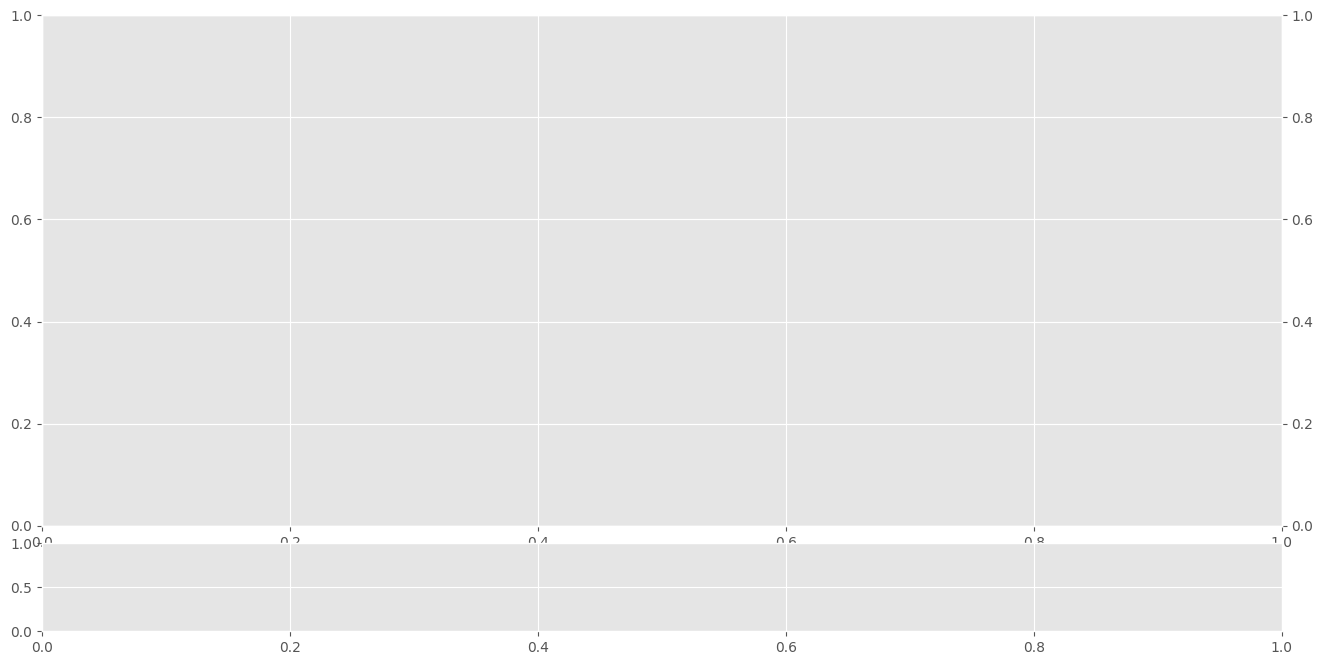

In [62]:
lookback_window_size = 50
data_path = "../data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]

lookback_window_size = 50

train_env = TradingEnv(train_df, lookback_window_size=lookback_window_size)

train_agent(train_env, visualize=False, train_episodes=1, training_batch_size=500)

Loss가 nan으로 나오는 것을 보아 학습이 제대로 진행되고 있지 않다는 것을 알 수 있다. 단계별로 뜯어가며 원인을 알아보도록 하자.

In [65]:
# Experience replay 메모리 초기화
memory = ReplayMemory(1000)
memory

array([[ 6439.55    ,  6515.      ,  6439.55    ,  6514.07    ,
         2564.814102, 10000.      , 10000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6514.78    ,  6523.23    ,  6445.      ,  6449.66    ,
         2638.245186, 10000.      , 10000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6449.62    ,  6480.      ,  6408.      ,  6439.47    ,
         3522.060908, 10000.      , 10000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6439.47    ,  6465.      ,  6378.      ,  6398.93    ,
         3855.135175, 10000.      , 10000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6398.09    ,  6453.      ,  6380.96    ,  6415.6     ,
         2207.248162, 10000.      , 10000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6415.6     ,  6471.56    ,  6390.      ,  6471.56    ,
         3093.525912, 10000.      , 10000.      ,     0.      ,
            0.      ,     0.      ],
       [ 6

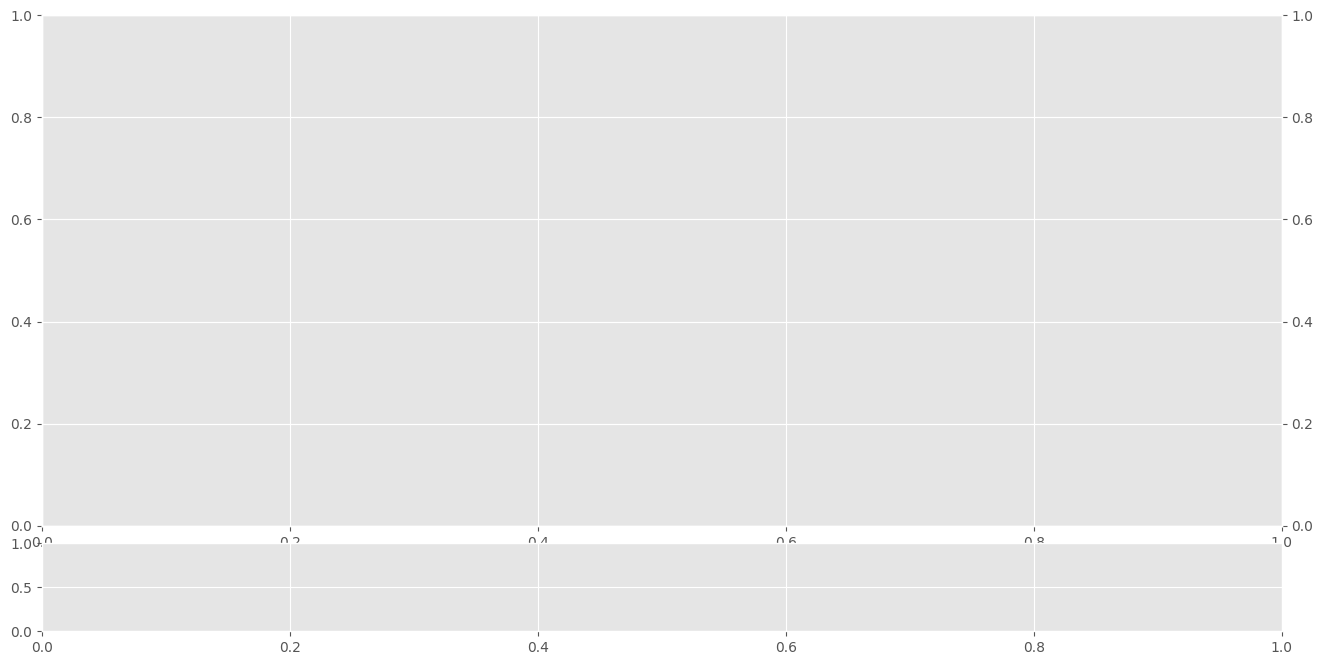

In [66]:
# State 초기화
state = train_env.reset()
state

State까지는 제대로 printe되고 있음을 알 수 있다. 다음으로 action을 잘 취하는지 알아보도록 하자.

In [67]:
action = train_env.act(state, testmode=False)
action

tensor([[0]], device='mps:0')

In [ ]:
            next_state, reward, done = env.step(action)
            if done:
                break
            #action_onehot = np.zeros(3)
            #action_onehot[action] = 1
            memory.push(state, action, next_state, reward) # Store the transition in memory
            state = next_state
            env.optimize_model() # perform one step of the optimization on the policy network

첫 거래에서 에이전트는 매도 결정을 내렸다. 이제 이를 바탕으로 step 함수를 작동시켜서 보상을 얻고 다음 state를 관찰하도록 하자.

In [68]:
next_state, reward, done = train_env.step(action)

In [69]:
next_state.shape

(50, 10)

In [70]:
reward

0.0

In [71]:
train_env.net_worth

10000.0

In [72]:
train_env.crypto_bought

0

거래를 잘 수행하여 가지고 있는 현금의 1/10을 사용해 비트코인을 매수했다. 다음으로 optimize 함수를 살펴보자

In [73]:
memory.push(state, action, next_state, reward)

In [75]:
state = next_state

Optimize 과정을 하나하나 뜯어보자

In [78]:
state_action_values = train_env.Target(next_state).gather(1, action)

TypeError: flatten() takes from 0 to 1 positional arguments but 2 were given

In [ ]:
# Train 모드로 변경
train_env.Behaviour.train()
criterion = nn.MSELoss()


In [76]:
train_env.optimize_model()

In [77]:
train_env.loss

0

In [ ]:
# 실제로 의사결정을 내린 behaviour policy network로 구한 Q값을 계산한다

# Target policy network로 현재 Q값을 계산한다.



In [ ]:
def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.Behaviour(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.Target(non_final_next_states).max(1).values

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.MSELoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.losses.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        #torch.nn.utils.clip_grad_value_(self.Policy.parameters(), 100)
        self.optimizer.step()
        
        # Update the target network every C step
        if self.current_step % self.C == 0:
            self.soft_update_target(self.Target, self.Behaviour)
    
    def soft_update_target(self, target, behaviour):
        for target_parameter, behaviour_parameter in zip(target.parameters(), behaviour.parameters()):
            target_parameter.data.copy_((1 - self.tau) * target_parameter.data + self.tau * behaviour_parameter)

In [59]:
train_env.loss

0

In [55]:
train_env.Target.

<generator object Module.parameters at 0x2b7f72180>
